## An idealized simulation of a radioactive tracer with an atmospheric origin usig OCIM

In [2]:
using AIBECS
t = empty_parameter_table()               # initialize table of parameters
add_parameter!(t, :λ, 1 / (5730*log(2))u"yr") # add the radioactive decay e-folding timescale
add_parameter!(t, :κ, 50u"m" / 10u"yr")
initialize_Parameters_type(t)             # Generate the parameter table

In [3]:
t

2×9 DataFrames.DataFrame. Omitted printing of 3 columns
│ Row │ symbol │ value      │ unit     │ printunit │ mean_obs │ variance_obs │
│     │ Symbol │ Float64    │ Unitful… │ Unitful…  │ Float64  │ Float64      │
├─────┼────────┼────────────┼──────────┼───────────┼──────────┼──────────────┤
│ 1   │ λ      │ 7.9784e-12 │ s^-1     │ yr^-1     │ NaN      │ NaN          │
│ 2   │ κ      │ 1.5844e-7  │ m s^-1   │ m yr^-1   │ NaN      │ NaN          │

In [4]:
# I added this cell for you to see how it prints nicely with the "print" units
# The table `t` prints the value in the SI units, 
# while the parameter p₀ prints in the units you used to create it
p₀

     λ = 2.52e-04 [yr⁻¹] (fixed)
     κ = 5.00e+00 [m yr⁻¹] (fixed)


AIBECS.Parameters{Float64}


In [5]:
const mask, grd, T_OCIM = OCIM1.load() ;
T_14c(p) = T_OCIM
iwet = findall(x -> x == 1, vec(mask));  # index to wet gridboxes

Loading OCIM1 with JLD2 ✅


In [6]:
dz1 = grd["dzt"][1]               # thickness of the top layer
z = vec(grd["ZT3d"])[iwet]        # depth of the gridbox centers
nwet = length(iwet)               # number of wet grid boxes
dv = vec(grd["DZT3d"])[iwet].*vec(grd["DYT3d"])[iwet].*vec(grd["DXT3d"])[iwet];

In [7]:
function sms_14c(R, p) # source minus sink of age
    λ = p.λ
    κ = p.κ
    return κ * (z .< 20) .* (1.0 .- R) / dz1 - λ.*R
end

sms_14c (generic function with 1 method)

In [8]:
T_matrices = (T_14c,)           # bundles all the transport matrices in a tuple
sources_minus_sinks = (sms_14c,) # bundles all the source-sink functions in a tuple
F, ∇ₓF = state_function_and_Jacobian(T_matrices, sources_minus_sinks, nwet) # generates the state function (and its Jacobian!)

(getfield(AIBECS, Symbol("#F#27")){getfield(AIBECS, Symbol("#T#23")){Tuple{typeof(T_14c)}},getfield(AIBECS, Symbol("#G#25")){Tuple{typeof(sms_14c)},getfield(AIBECS, Symbol("#tracers#21")){Int64,Int64}}}(getfield(AIBECS, Symbol("#T#23")){Tuple{typeof(T_14c)}}((T_14c,)), getfield(AIBECS, Symbol("#G#25")){Tuple{typeof(sms_14c)},getfield(AIBECS, Symbol("#tracers#21")){Int64,Int64}}((sms_14c,), getfield(AIBECS, Symbol("#tracers#21")){Int64,Int64}(200160, 1))), getfield(AIBECS, Symbol("#∇ₓF#29")){getfield(AIBECS, Symbol("#T#23")){Tuple{typeof(T_14c)}},getfield(AIBECS, Symbol("#∇ₓG#28")){Tuple{typeof(sms_14c)},Int64,Int64}}(getfield(AIBECS, Symbol("#T#23")){Tuple{typeof(T_14c)}}((T_14c,)), getfield(AIBECS, Symbol("#∇ₓG#28")){Tuple{typeof(sms_14c)},Int64,Int64}((sms_14c,), 200160, 1)))

In [14]:
x₀ = ones(nwet)
prob = SteadyStateProblem(F, ∇ₓF, x₀, p₀)
R = solve(prob, CTKAlg())
c14age = -log.(R)/p₀.λ;

In [15]:
lat, lon = vec(grd["yt"]), vec(grd["xt"]);

In [16]:
ENV["MPLBACKEND"]="qt5agg"
using PyPlot, PyCall

In [17]:
c14age_3d = NaN * mask     # creates a 3D array of NaNs
c14age_3d[iwet] = c14age   # Fills the wet grid boxes with the age values
size(c14age_3d)            # Just to check the size of age_3D

(91, 180, 24)

In [18]:
depth = vec(grd["zt"])
iz = findfirst(depth .> 700)
iz, depth[iz]

(11, 757.7081696779262)

In [19]:
c14age_3d_1000m_yr = c14age_3d[:,:,iz] * ustrip(1.0u"s" |> u"yr")

91×180 Array{Float64,2}:
  NaN       NaN       NaN       NaN      …   NaN       NaN       NaN    
  NaN       NaN       NaN       NaN          NaN       NaN       NaN    
  NaN       NaN       NaN       NaN          NaN       NaN       NaN    
  NaN       NaN       NaN       NaN          NaN       NaN       NaN    
  NaN       NaN       NaN       NaN          NaN       NaN       NaN    
  NaN       NaN       NaN       NaN      …   NaN       NaN       NaN    
  NaN       NaN       NaN       NaN          NaN       NaN       NaN    
  NaN       NaN       NaN       NaN          NaN       NaN       NaN    
  NaN       NaN       NaN       NaN          NaN       NaN       NaN    
 1342.82    NaN       NaN       NaN          NaN       NaN      1342.79 
 1339.91   1336.99   1334.25   1329.63   …  1342.4    1342.14   1341.25 
 1346.55   1343.69   1340.57   1336.83      1348.46   1348.21   1347.44 
 1350.4    1347.7    1345.53   1343.22      1353.99   1352.69   1351.33 
    ⋮                     

┌ Info: Running `conda install -y Cartopy` in root environment
└ @ Conda /Users/fprimeau/.julia/packages/Conda/CpuvI/src/Conda.jl:112


Solving environment: ...working... done

# All requested packages already installed.



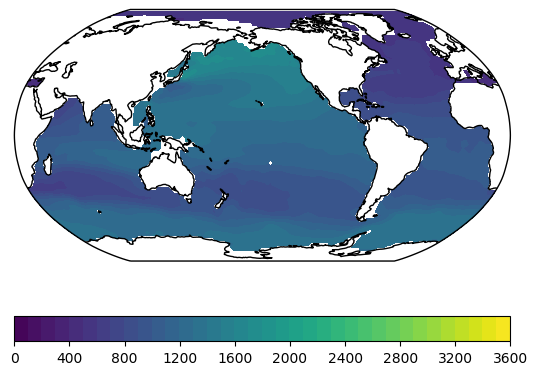

PyObject <matplotlib.colorbar.Colorbar object at 0x13941e5c0>

In [20]:
using Conda; Conda.add("Cartopy")
#Conda.add("cartopy.crs")

ccrs = pyimport("cartopy.crs")
ax = subplot(projection=ccrs.Robinson(central_longitude=-155.0))
ax.coastlines()
# making it cyclic for Cartopy
lon_cyc = [lon; 360+lon[1]] 
age_cyc = hcat(c14age_3d_1000m_yr, c14age_3d_1000m_yr[:,1])
# And plot
p = contourf(lon_cyc, lat, age_cyc, levels=0:100:3600, transform=ccrs.PlateCarree(), zorder=-1)
colorbar(p, orientation="horizontal")